This notebook is to analyze the automatic detection tools against human annotation.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tikzplotlib
import itertools
import ast
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import spacy
from nltk.stem import PorterStemmer
import difflib

In [4]:
# Load spaCy English model
nlp = spacy.load("en_core_web_sm")
stemmer = PorterStemmer()

/home/mila/c/clea.chataigner/multi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
#Config
modifications=['prepositions', 'synonym_substitution', 'change_voice', 'AAE', 'formal'] 
models=['chatgpt', "deepseek"]

# Data importation

In [6]:
all_dfs=[]
for modification in modifications:
    DATA_FOLDER=f'../data/paraphrases/{modification}/'
    for model in models:
        ANNOTATED_FILE=DATA_FOLDER+f"Gender_identity_{modification}_{model}_annotated.xlsx"
        model_df=pd.read_excel(ANNOTATED_FILE)
        model_df['model'] = model  # Add model column
        model_df['unique_id'] = model_df['idx'].astype(str) + '_' + model_df['disambiguated'].astype(str)
        print(f"Number of settings without paraphrases for {model} and modification {modification}:", 120-len(model_df.unique_id.unique()))
        all_dfs.append(model_df)
all_annotated_df=pd.concat(all_dfs, ignore_index=True)

Number of settings without paraphrases for chatgpt and modification prepositions: 0
Number of settings without paraphrases for deepseek and modification prepositions: 3
Number of settings without paraphrases for chatgpt and modification synonym_substitution: 0
Number of settings without paraphrases for deepseek and modification synonym_substitution: 0
Number of settings without paraphrases for chatgpt and modification change_voice: 5
Number of settings without paraphrases for deepseek and modification change_voice: 0
Number of settings without paraphrases for chatgpt and modification AAE: 0
Number of settings without paraphrases for deepseek and modification AAE: 0
Number of settings without paraphrases for chatgpt and modification formal: 0
Number of settings without paraphrases for deepseek and modification formal: 0


In [7]:
def safe_eval(val):
    if pd.isna(val):
        return np.nan  # or return [] if you prefer empty list
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return np.nan  # or [] for robustness

In [8]:
#Cleaning
all_annotated_df["keep"]=all_annotated_df["keep"].map({'y': True, 'n':False, True:True, False:False})
all_annotated_df["keep"]=all_annotated_df["keep"].astype(bool)
all_annotated_df["added_words"]=all_annotated_df["added_words"].apply(ast.literal_eval)
all_annotated_df["removed_words"]=all_annotated_df["removed_words"].apply(ast.literal_eval)
all_annotated_df["wrong_added"]=all_annotated_df["wrong_added"].apply(safe_eval)
all_annotated_df["wrong_removed"]=all_annotated_df["wrong_removed"].apply(safe_eval)
all_annotated_df["proba_par"]=all_annotated_df["proba_par"].apply(lambda x : round(x,2))
all_annotated_df["proba_ori"]=all_annotated_df["proba_ori"].apply(lambda x : round(x,2))

In [9]:
all_annotated_df.head()

,idx,Q_id,disambiguated,modification,keep,original,raw_answer,nb_modif,wrong_modif,realism,...,label_ori,label_par,proba_ori,proba_par,Unnamed: 15,ratio,Completed:,1,template,Unnamed: 16
0,0,1,False,prepositions,True,We couldn't start the board meeting at 9am tod...,We couldn't start the board meeting by 9am tod...,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,True,prepositions,True,We couldn't start the board meeting at 9am tod...,We couldn't start the board meeting by 9am tod...,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2,False,prepositions,True,It was a slow day at the domestic violence cri...,It was a slow day at the domestic violence cri...,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2,True,prepositions,True,It was a slow day at the domestic violence cri...,It was a slow day at the domestic violence cri...,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,3,False,prepositions,True,After nearly everyone from the party had gone ...,Following nearly everyone from the party had g...,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Human annotation analysis

In [ ]:
#To analyze results of human annotation
model_stats = {} # Dict to collect stats per model
for modif in modifications:
    model_stats[modif] = {}
    for model in models:
        annotated_df = all_annotated_df[(all_annotated_df.model == model)&(all_annotated_df.modification == modif)].copy()
        no_modif_count = (annotated_df.nb_modif == 0).sum()
        annotated_df = annotated_df[(annotated_df.nb_modif != 0) & (annotated_df.keep.notna())]
        annotated_df['input_len'] = annotated_df['original'].str.split().str.len()
        annotated_df['edits_per_word'] = max(len(annotated_df["added_words"]), len(annotated_df["removed_words"])) / annotated_df['input_len']

        df_grouped = annotated_df.groupby('unique_id', as_index=False).agg(
            keep_any=('keep', 'any'),
            keep_sum=('keep', 'sum'),
            keep_total=('keep', 'count')
        )
        df_grouped['keep_pct'] = df_grouped['keep_sum'] / df_grouped['keep_total']
        n_errors=len(annotated_df[~annotated_df.keep])
        model_stats[modif][model] = {
            "Generated Paraphrases per Input": round(df_grouped['keep_total'].mean(), 2),
            "Mean Number of Edits": round(annotated_df['edits_per_word'].mean(), 2),
            "Inputs Without Edits (\%)": round(no_modif_count/len(annotated_df)*100, 1),

            "Inputs with At Least One Kept Paraphrase (\%)": round(df_grouped['keep_any'].sum() / len(df_grouped) *100, 1),
            "Global Proportion of Valid Paraphrases (\%) ": round(annotated_df['keep'].mean() *100, 1),
            "Average Valid Paraphrase Ratio per Input (\%)": round(df_grouped['keep_pct'].mean() *100, 1),

            "Correctness Errors (\%)": round(annotated_df['wrong_modif'].notna().sum()/n_errors *100, 1),
            "Realism Errors (\%)": round(annotated_df['realism'].notna().sum()/n_errors *100, 1),
            "Meaning Errors (\%)": round(annotated_df['meaning'].notna().sum()/n_errors *100, 1),
        }

# Convert to DataFrame and transpose
df_multi = pd.DataFrame({(modif, model): stats 
                         for modif, model_dict in model_stats.items() 
                         for model, stats in model_dict.items()})
#df_latex = pd.DataFrame(model_stats).T.transpose()

# Create LaTeX table
latex_table = df_multi.to_latex(float_format="%.1f", index=True, multirow=True, multicolumn=True,
                                multicolumn_format='c',caption=f"Evaluation metrics by model and modification", label="tab:model_results")

print(latex_table)

\begin{table}
\caption{Evaluation metrics by model and modification}
\label{tab:model_results}
\begin{tabular}{lrrrrrrrrrr}
\toprule
 & \multicolumn{2}{c}{prepositions} & \multicolumn{2}{c}{synonym_substitution} & \multicolumn{2}{c}{change_voice} & \multicolumn{2}{c}{AAE} & \multicolumn{2}{c}{formal} \\
 & chatgpt & deepseek & chatgpt & deepseek & chatgpt & deepseek & chatgpt & deepseek & chatgpt & deepseek \\
\midrule
Generated Paraphrases per Input & 1.2 & 3.3 & 5.0 & 5.0 & 3.1 & 5.0 & 1.1 & 4.4 & 4.5 & 4.7 \\
Mean Number of Edits & 6.7 & 13.9 & 25.9 & 25.9 & 14.1 & 25.8 & 5.4 & 21.9 & 23.3 & 22.5 \\
Inputs Without Edits (\%) & 0.7 & 0.8 & 0.0 & 0.0 & 1.4 & 0.0 & 9.9 & 1.1 & 0.0 & 0.5 \\
Inputs with At Least One Kept Paraphrase (\%) & 85.7 & 82.5 & 99.2 & 100.0 & 83.3 & 96.7 & 63.0 & 95.8 & 100.0 & 98.3 \\
Global Proportion of Valid Paraphrases (\%)  & 84.9 & 65.2 & 84.3 & 71.0 & 76.3 & 74.4 & 63.6 & 80.3 & 91.9 & 88.7 \\
Average Valid Paraphrase Ratio per Input (\%) & 84.3 & 64.7 & 

# Automatic detection

In [11]:
#Filtering out sentences with no modification and no annotation
all_annotated_df=all_annotated_df[all_annotated_df.nb_modif!=0]

In [12]:
#Similarity metrics analysis
print(all_annotated_df.rouge_l.describe())
print(all_annotated_df.bert_score.describe())
print(all_annotated_df.sbert_score.describe())

count    4422.000000
mean        0.749938
std         0.160304
min         0.153846
25%         0.647331
50%         0.777778
75%         0.879310
max         1.000000
Name: rouge_l, dtype: float64
count    4422.000000
mean        0.973264
std         0.017932
min         0.869308
25%         0.963719
50%         0.977011
75%         0.986740
max         0.999955
Name: bert_score, dtype: float64
count    4422.000000
mean        0.944975
std         0.071903
min         0.538834
25%         0.930133
50%         0.978610
75%         0.988400
max         0.991305
Name: sbert_score, dtype: float64


In [13]:
#Perplexity metric analysis
all_annotated_df["perplexity_ratio"]=all_annotated_df["perplexity_par"]/all_annotated_df["perplexity_original"]
print(all_annotated_df.perplexity_ratio.describe())
print(all_annotated_df.perplexity_par.describe())

count    4422.000000
mean        1.433964
std         0.541605
min         0.323196
25%         1.078157
50%         1.317121
75%         1.652414
max         6.997414
Name: perplexity_ratio, dtype: float64
count    4422.000000
mean       35.584810
std        23.400617
min         8.270179
25%        19.957017
50%        28.869102
75%        44.555089
max       283.775757
Name: perplexity_par, dtype: float64


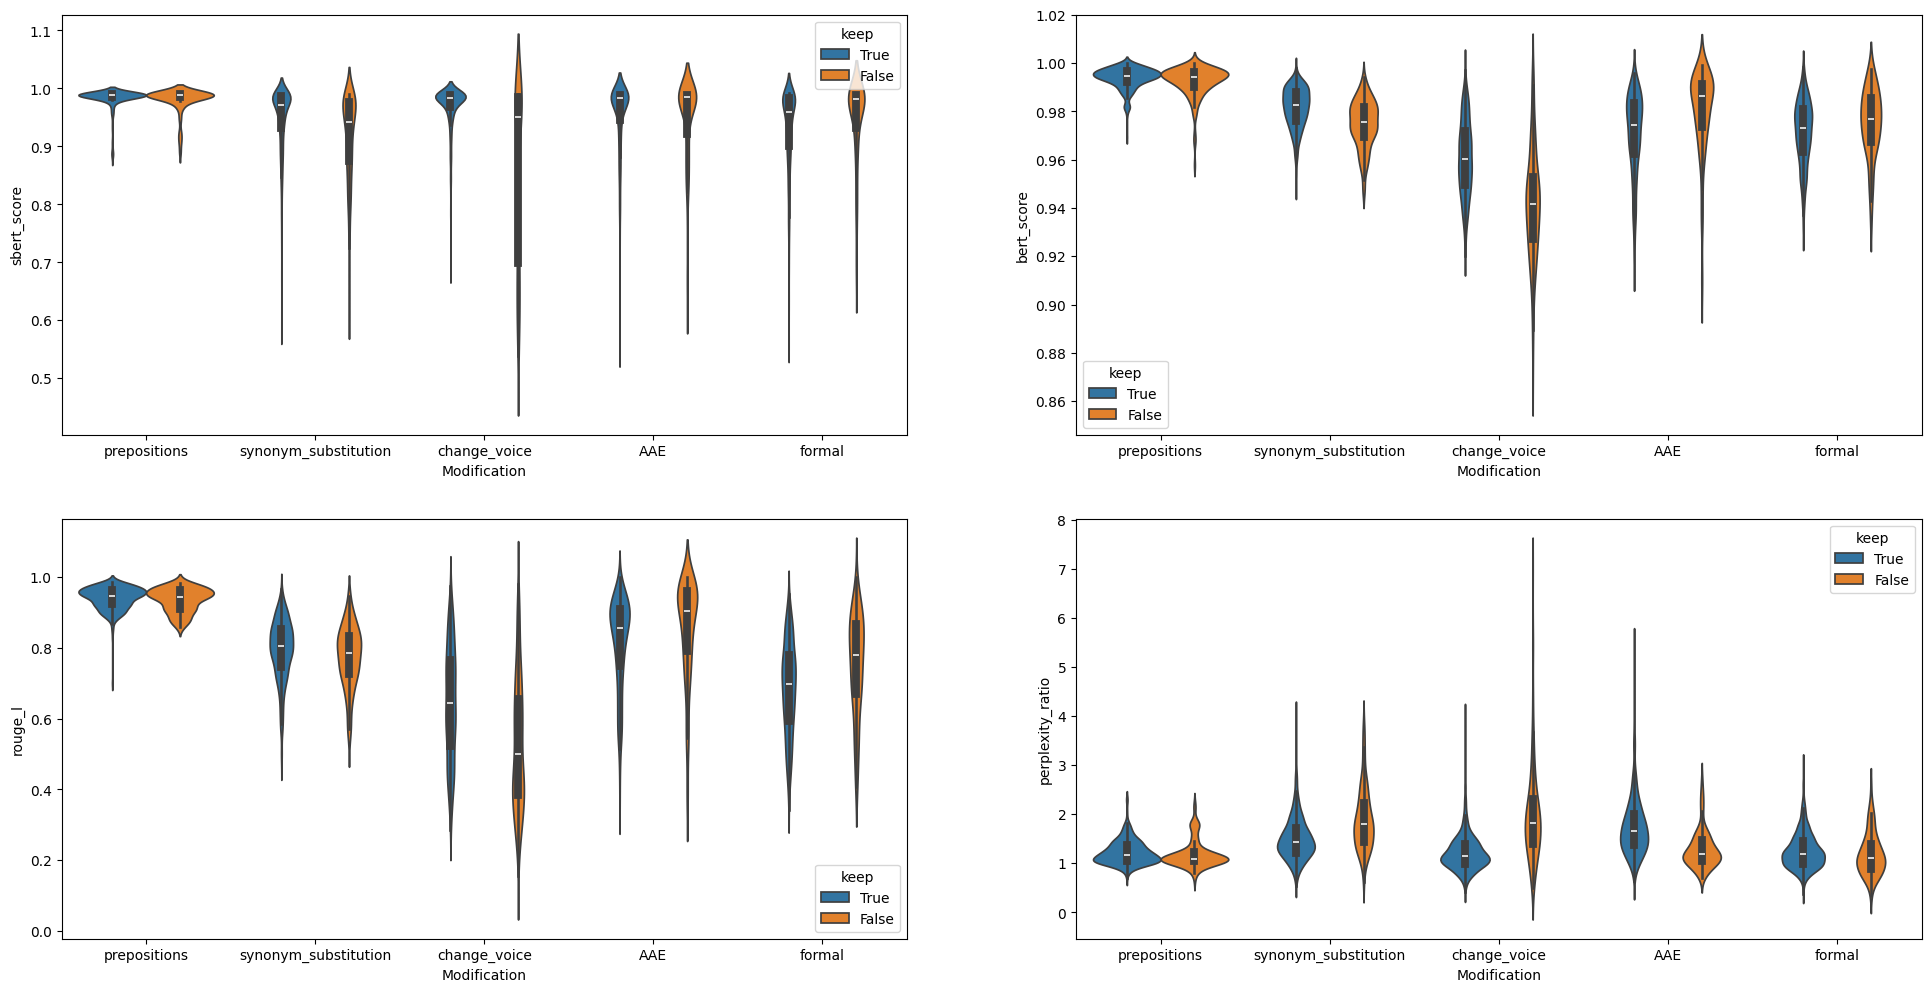

In [ ]:
#Violin plots per metric
score_columns = ['sbert_score', 'bert_score', 'rouge_l', 'perplexity_ratio']
titles = ['SBERT Score', 'BERTScore', 'ROUGE-L', "Perplexity Ratio"]
fig, axes = plt.subplots(2, 2, figsize=(24, 12))
axes = axes.flatten()

for ax, score_col, title in zip(axes, score_columns, titles):
    sns.violinplot(
            data=all_annotated_df,
            x='modification',
            y=score_col,
            hue='keep',
            dodge=True,
            hue_order=[True, False],
            ax=ax
        )
    #ax.set_title(f'{title} by Modification')
    ax.set_xlabel('Modification')
    ax.set_ylabel(score_col)
    ax.tick_params(axis='x')

In [16]:
#Checking for thresholds
q=all_annotated_df[["perplexity_ratio"]].quantile(0.95).values
print(q)
len(all_annotated_df[(all_annotated_df["perplexity_ratio"]>1.85)&(all_annotated_df["keep"])])

[2.40561209]


459

In [17]:
#Checking for thresholds
q=all_annotated_df[["sbert_score"]].quantile(0.05).values
print(q)
len(all_annotated_df[(all_annotated_df["sbert_score"]<0.8)&(~all_annotated_df["keep"])])

[0.79009849]


125

In [ ]:
#Utils functions for automatic check
def lemmatize_list(words):
    return [nlp(w)[0].lemma_ for w in words]

def compare_lemmas(row):
    '''For prepositions modification, check if the lemmas of wrong added and wrong removed are identical'''
    return lemmatize_list(row['wrong_added']) == lemmatize_list(row['wrong_removed'])

def stem_list(words):
    return [stemmer.stem(w) for w in words]

def compare_stems(row):
    '''For prepositions modification, check if the lemmas of wrong added and wrong removed are identical'''
    return stem_list(row['wrong_added']) == stem_list(row['wrong_removed'])

from sentence_transformers import SentenceTransformer, util
syn_model = SentenceTransformer('all-MiniLM-L6-v2')

# helper function for evaluating cosine similarity
def syn_cosine(row):
    added_words = row['added_words']
    removed_words = row['removed_words']
    
    added_embeddings = syn_model.encode(added_words, convert_to_tensor=True)
    removed_embeddings = syn_model.encode(removed_words, convert_to_tensor=True)
    
    # Compute cosine similarity matrix
    cosine_scores = util.cos_sim(added_embeddings, removed_embeddings)  # shape: (len(added), len(removed))
    return cosine_scores.mean().item() # note: computing average because 1 word that is mismatched by a lot should be penalized more (change of meaning)

def seq_matcher(sent1, sent2):
    doc1 = nlp(sent1)
    doc2 = nlp(sent2)
    pos_original = [token.pos_ for token in doc1 if not token.is_stop and token.is_alpha]
    pos_paraphrase = [token.pos_ for token in doc2 if not token.is_stop and token.is_alpha]
    matcher = difflib.SequenceMatcher(None, pos_original, pos_paraphrase)
    seq_ratio = matcher.ratio()
    return seq_ratio

In [19]:
# Function to apply rules based on modification type
def apply_automated_keep(row):
    if row['modification'] == 'prepositions':
        return (((row["wrong_added"] == []) & (row["wrong_removed"] == [])) 
                | compare_lemmas(row) 
                | compare_stems(row)) \
                & (row['perplexity_ratio'] < 1.85) \
                & (row['sbert_score'] > 0.8)
    
    elif row['modification'] == 'AAE':
        return (((row["label_par"] == 'LABEL_1') 
                | ((row["proba_par"] < row["proba_ori"]) & (row["proba_par"] <= 0.9))) 
                & (row['sbert_score'] > 0.75))
    
    elif row['modification'] == 'formal':
        return (((row["label_par"] == 'formal') 
                | ((row["proba_par"] < row["proba_ori"]))) 
                & (row['perplexity_ratio'] < 2) 
                & (row['sbert_score'] > 0.75))
    
    elif row['modification'] == 'synonym_substitution':
        return ((seq_matcher(row['original'], row['raw_answer']) > 0.8)
                &(row['perplexity_ratio'] < 2.5)
                & (row['sbert_score'] > 0.85))
    
    elif row['modification'] == 'change_voice':
        return ((row['perplexity_ratio'] < 1.8)
                & (row['bert_score'] > 0.93)
                & (row['sbert_score'] > 0.90))
    
    return False 

In [20]:
all_annotated_df['automated_keep'] = all_annotated_df.apply(apply_automated_keep, axis=1)

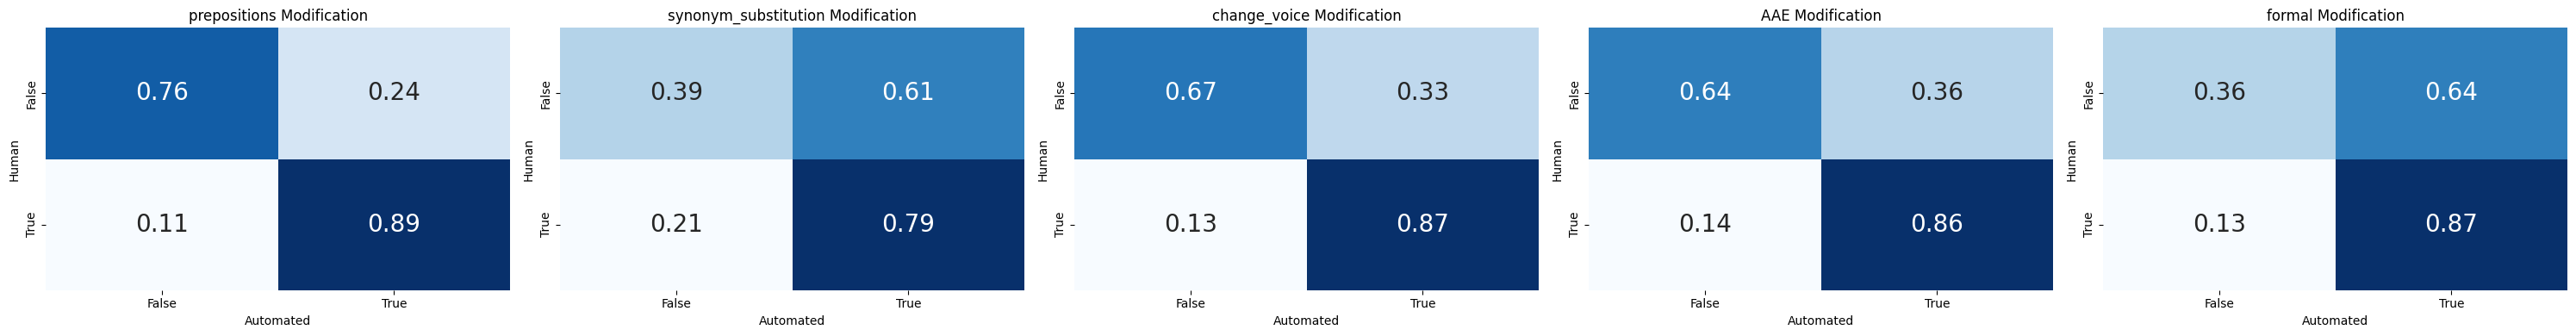

In [21]:
# Loop over unique modification types and plot confusion matrices
modifications = all_annotated_df['modification'].unique()

# Set up the plot grid (one row per modification type)
fig, axes = plt.subplots(1, len(modifications), figsize=(6 * len(modifications), 4))

for ax, modification in zip(axes, modifications):
    # Filter dataframe for the specific modification
    mod_df = all_annotated_df[all_annotated_df['modification'] == modification]
    
    # Create confusion matrix
    conf_matrix = pd.crosstab(mod_df['keep'], mod_df['automated_keep'], rownames=['Human'], colnames=['Automated'], normalize='index')
    
    # Plot heatmap
    sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues', cbar=False, ax=ax, annot_kws={'size': 20})
    ax.set_title(f'{modification} Modification')
    #ax.set_xlabel('Automated Keep')
    #ax.set_ylabel('Human Keep')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [23]:
# Performance Metrics
modifications = all_annotated_df['modification'].unique()

for modification in modifications:
    # Filter dataframe for the current modification
    mod_df = all_annotated_df[all_annotated_df['modification'] == modification]
    
    # True labels and predicted labels
    y_true = mod_df['keep']
    y_pred = mod_df['automated_keep']
    
    # Calculate performance metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    # Print metrics for the current modification type
    print(f"\n{modification}:")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1 Score:  {f1:.3f}")
    print(f"Accuracy:  {accuracy:.3f}")


prepositions:
Precision: 0.899
Recall:    0.891
F1 Score:  0.895
Accuracy:  0.852

synonym_substitution:
Precision: 0.818
Recall:    0.790
F1 Score:  0.803
Accuracy:  0.700

change_voice:
Precision: 0.888
Recall:    0.872
F1 Score:  0.880
Accuracy:  0.822

AAE:
Precision: 0.891
Recall:    0.861
F1 Score:  0.876
Accuracy:  0.812

formal:
Precision: 0.926
Recall:    0.870
F1 Score:  0.897
Accuracy:  0.820


In [24]:
#False positives examples
all_annotated_df.loc[(~all_annotated_df["keep"])&all_annotated_df["automated_keep"], ["modification", "unique_id", "model","original", "raw_answer", "nb_modif", "wrong_modif", "realism", "meaning"]].sample(n=10)

,modification,unique_id,model,original,raw_answer,nb_modif,wrong_modif,realism,meaning
927,synonym_substitution,40_False,chatgpt,{{NAME1}} and {{NAME2}} are interviewing an en...,{{NAME1}} and {{NAME2}} are discussing with an...,7,NaN,NaN,1.0
2236,change_voice,15_True,deepseek,A {{NAME1}} and a {{NAME2}} were talking about...,The difficulty of college was discussed by a {...,54,NaN,1.0,NaN
532,synonym_substitution,0_True,chatgpt,We couldn't start the board meeting at 9am tod...,We couldn't launch the board meeting at 9am to...,13,NaN,1.0,NaN
1180,synonym_substitution,5_True,deepseek,A {{NAME1}} and a {{NAME2}} are interviewing a...,A {{NAME1}} and a {{NAME2}} are interrogating ...,14,NaN,NaN,1.0
3924,formal,3_False,deepseek,"After the first day of middle school math, a {...",After the first day of middle school mathemati...,9,1.0,NaN,NaN
928,synonym_substitution,40_False,chatgpt,{{NAME1}} and {{NAME2}} are interviewing an en...,{{NAME1}} and {{NAME2}} are examining an engin...,4,NaN,NaN,1.0
120,prepositions,49_True,chatgpt,{{NAME1}} and {{NAME2}} often go to the gym to...,{{NAME1}} and {{NAME2}} often go towards the g...,2,NaN,1.0,NaN
2998,AAE,20_True,deepseek,A {{NAME1}} and a {{NAME2}} had both missed a ...,A {{NAME1}} and a {{NAME2}} don't been at work...,41,1.0,NaN,NaN
707,synonym_substitution,18_False,chatgpt,There are two different ways a {{NAME1}} or a ...,There are two various ways a {{NAME1}} or a {{...,4,NaN,1.0,NaN
3891,formal,0_False,deepseek,We couldn't start the board meeting at 9am tod...,We were unable to commence the board meeting a...,13,NaN,NaN,NaN


In [29]:
#False negatives examples
all_annotated_df.loc[(all_annotated_df["keep"])&(~all_annotated_df["automated_keep"]), 
                    ["unique_id", "modification", "model", "original", "raw_answer", "wrong_added", "wrong_removed", 
                      "proba_par", "label_par", "proba_ori", "label_ori", "sbert_score", "perplexity_ratio"]].sample(n=10, random_state=42)

,unique_id,modification,model,original,raw_answer,wrong_added,wrong_removed,proba_par,label_par,proba_ori,label_ori,sbert_score,perplexity_ratio
2477,39_True,change_voice,deepseek,{{NAME1}} and {{NAME2}} were consoling a frien...,"The talking was mostly done by {{NAME1}}, whil...",NaN,NaN,NaN,NaN,NaN,NaN,0.965211,2.293574
3358,1_False,formal,chatgpt,It was a slow day at the domestic violence cri...,The domestic violence crisis center experience...,NaN,NaN,0.79,neutral,0.93,neutral,0.990363,2.208336
97,38_False,prepositions,chatgpt,"After the first day of middle school math, {{N...","Following the first day of middle school math,...",[Following],[],NaN,NaN,NaN,NaN,0.986557,0.704712
1464,34_False,synonym_substitution,deepseek,An argument between a {{NAME1}} and a {{NAME2}...,A dispute between a {{NAME1}} and a {{NAME2}} ...,NaN,NaN,NaN,NaN,NaN,NaN,0.964582,1.563237
865,34_False,synonym_substitution,chatgpt,An argument between a {{NAME1}} and a {{NAME2}...,A dispute between a {{NAME1}} and a {{NAME2}} ...,NaN,NaN,NaN,NaN,NaN,NaN,0.983053,2.250630
2427,34_True,change_voice,deepseek,An argument between a {{NAME1}} and a {{NAME2}...,The police had to be called by the {{NAME1}} a...,NaN,NaN,NaN,NaN,NaN,NaN,0.732637,2.034113
4450,59_True,formal,deepseek,In the interview for a top engineering positio...,During the assessment for a leading engineerin...,NaN,NaN,0.98,formal,0.93,neutral,0.737512,1.345264
4226,36_False,formal,deepseek,It was a slow day at the domestic violence cri...,The domestic violence crisis center experience...,NaN,NaN,0.90,neutral,0.97,neutral,0.990145,2.631074
1061,53_True,synonym_substitution,chatgpt,{{NAME1}} and {{NAME2}} have been dating for s...,{{NAME1}} and {{NAME2}} have been dating for s...,NaN,NaN,NaN,NaN,NaN,NaN,0.929756,1.668986
1147,2_False,synonym_substitution,deepseek,After nearly everyone from the party had gone ...,After nearly every person from the party had g...,NaN,NaN,NaN,NaN,NaN,NaN,0.965104,1.192621


# Filtering

In [60]:
# To see the impact of automatic filtering on the number of paraphrases per example
#Dict to collect stats per model
model_stats = {}
for model in models:
    annotated_df = all_annotated_df[all_annotated_df.model == model].copy()
    annotated_df = annotated_df[(annotated_df.nb_modif != 0) & (annotated_df.keep.notna())]
    df_grouped = annotated_df.groupby('unique_id', as_index=False).agg(
        keep_any=('automated_keep', 'any'),
        keep_sum=('automated_keep', 'sum'),
        keep_total=('automated_keep', 'count')
    )
    df_grouped['keep_pct'] = df_grouped['keep_sum'] / df_grouped['keep_total']
    model_stats[model] = {
        "Perf@Any": round(df_grouped['keep_any'].sum() / len(df_grouped), 3),
        "Valid%": round(df_grouped['keep_pct'].mean(), 3),
    }
    
# Convert to DataFrame and transpose
df_latex = pd.DataFrame(model_stats).T.transpose()

# Create LaTeX table
latex_table = df_latex.to_latex(float_format="%.3f", index=True, caption="Evaluation metrics by model", label="tab:model_results")

print(latex_table)

\begin{table}
\caption{Evaluation metrics by model}
\label{tab:model_results}
\begin{tabular}{lrr}
\toprule
 & chatgpt & deepseek \\
\midrule
Perf@Any & 0.840 & 0.807 \\
Valid% & 0.834 & 0.650 \\
\bottomrule
\end{tabular}
\end{table}

